# Problem

Given the following dataset, can you create a decision tree to predict customer churn? For simplicity, you can set the maximum depth of the decision tree to 4. For the purpose of this exercise, you do not need to optimize the model. 

In [99]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#libraries to help with model building
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# To get different metric scores
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from sklearn.model_selection import GridSearchCV

### Solution

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/erood/interviewqs.com_code_snippets/master/Datasets/teleco_user_data.csv')

### View the first and last 5 rows of the dataset.

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


### Understand the shape of the dataset.

In [7]:
df.shape

(7043, 21)

* The dataset has 7043 rows and 21 columns 

### Check the data types of the columns for the dataset.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


* 18 categories are categorical, while only 3 are integers or floats.  This means we will probably have to evaluate each categorical column, determine whether it is necessary, and convert to dummy variables if it is, or drop if it isnt. 
* There are no null values in the data.

##### Converting TotalCharges to float

When we initially tried to convert it directly to a float, an error arose indicating that there was at least one non-null value represented by a space, that is considered a string, and cannot be converted to a float directly.  Lets deal with the space first...

In [37]:
# Code used that resulted in error..
'''
df['TotalCharges'] = df['TotalCharges'].astype(float, errors = 'raise')
'''

"\ndf['TotalCharges'] = df['TotalCharges'].astype(float, errors = 'raise')\n"

In [39]:
print(df['TotalCharges'].loc[df['TotalCharges']== ' '])

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object


We can see this occurs 11 times.  It would be best to simply drop these rows.  11 rows out of a total of 7000+ is not significant

In [40]:
#Replacing spaces with null values in total charges column
df['TotalCharges'] = df['TotalCharges'].replace(' ',np.nan)

In [41]:
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [42]:
#Dropping null values from total charges column which contain .15% missing data 
df = df[df['TotalCharges'].notnull()]
df = df.reset_index()[df.columns]

##### Converting Object categories to categorical

We need to change all the columns listed as object to categorical data.  First, we can drop customerID. After, we can convert all the No Service answers in various columns to No.  Then we can convert the columns to categories

In [43]:
df = df.drop(['customerID'], axis=1)

In [45]:
#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    df[i]  = df[i].replace({'No internet service' : 'No'})

In [46]:
#replace 'No phone service' to No for the following columns
replace_cols = [ 'MultipleLines']
for i in replace_cols : 
    df[i]  = df[i].replace({'No phone service' : 'No'})

In [34]:
## Converting the data type of categorical features to 'category'
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
            'PaperlessBilling', 'PaymentMethod', 'Churn']
df[cat_cols] = df[cat_cols].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   int64   
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

### Summary of the dataset.

In [48]:
df.describe(include=['category']).T

,count,unique,top,freq
gender,7032,2,Male,3549
Partner,7032,2,No,3639
Dependents,7032,2,No,4933
PhoneService,7032,2,Yes,6352
MultipleLines,7032,2,No,4065
InternetService,7032,3,Fiber optic,3096
OnlineSecurity,7032,2,No,5017
OnlineBackup,7032,2,No,4607
DeviceProtection,7032,2,No,4614
TechSupport,7032,2,No,4992


In [49]:
for i in cat_cols:
    print('Unique values in',i, 'are :')
    print(df[i].value_counts())
    print('*'*50)

Unique values in gender are :
Male      3549
Female    3483
Name: gender, dtype: int64
**************************************************
Unique values in Partner are :
No     3639
Yes    3393
Name: Partner, dtype: int64
**************************************************
Unique values in Dependents are :
No     4933
Yes    2099
Name: Dependents, dtype: int64
**************************************************
Unique values in PhoneService are :
Yes    6352
No      680
Name: PhoneService, dtype: int64
**************************************************
Unique values in MultipleLines are :
No     4065
Yes    2967
Name: MultipleLines, dtype: int64
**************************************************
Unique values in InternetService are :
Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64
**************************************************
Unique values in OnlineSecurity are :
No     5017
Yes    2015
Name: OnlineSecurity, dtype: int64
***************

### Data Preparation

* We have 15 categorical independent variables but 12 of them are binary.
* We will convert the 12 binary categories from Yes/No to 1/0
* So we will only make dummies for InternetService, Contract and PaymentMethod.

In [58]:
df.gender = df.gender.map(dict(Male=1, Female=0))

In [59]:
df.Partner = df.Partner.map(dict(Yes=1, No=0))

In [72]:
df.Dependents = df.Dependents.map(dict(Yes=1, No=0))

In [61]:
df.PhoneService = df.PhoneService.map(dict(Yes=1, No=0))

In [62]:
df.MultipleLines = df.MultipleLines.map(dict(Yes=1, No=0))

In [79]:
df.OnlineSecurity = df.OnlineSecurity.map(dict(Yes=1, No=0))

In [63]:
df.OnlineBackup = df.OnlineBackup.map(dict(Yes=1, No=0))

In [65]:
df.DeviceProtection = df.DeviceProtection.map(dict(Yes=1, No=0))

In [66]:
df.TechSupport = df.TechSupport.map(dict(Yes=1, No=0))

In [67]:
df.StreamingTV = df.StreamingTV.map(dict(Yes=1, No=0))

In [68]:
df.StreamingMovies = df.StreamingMovies.map(dict(Yes=1, No=0))

In [69]:
df.PaperlessBilling = df.PaperlessBilling.map(dict(Yes=1, No=0))

In [70]:
df.Churn = df.Churn.map(dict(Yes=1, No=0))

In [84]:
X = df.drop(['Churn'], axis=1)
Y = df[['Churn']] 

X = pd.get_dummies(X, columns=['InternetService', 'Contract', 'PaymentMethod'],drop_first=True)

#Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state = 1)

In [85]:
y_train.value_counts()

Churn
0        3608
1        1314
dtype: int64

## Build Decision Tree Model

We will build our model using the DecisionTreeClassifier function. Using default 'gini' criteria to split. Other option include 'entropy'.  

In [87]:
X_train.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [93]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1, max_depth=4)
dTree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [94]:
prob_train = dTree.predict_proba(X_train)
pred_train = dTree.predict(X_train)

prob_test = dTree.predict_proba(X_test)
pred_test = dTree.predict(X_test)

In [97]:
## Defining a function for better visualization of confusion matrix
def make_confusion_matrix(y_actual,y_predict,labels=[1, 0]):
    '''
    y_predict: prediction of class
    y_actual : ground truth  
    '''
    cm=confusion_matrix( y_actual, y_predict, labels=[1, 0])
    data_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ['1','0']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (7,5))
    sns.heatmap(data_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

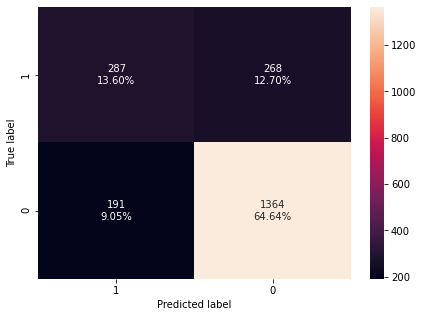

In [100]:
# let us make confusion matrix on test set
make_confusion_matrix(y_test,pred_test)

## Visualizing the Decision Tree

In [101]:
feature_names = list(X.columns)
print(feature_names)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


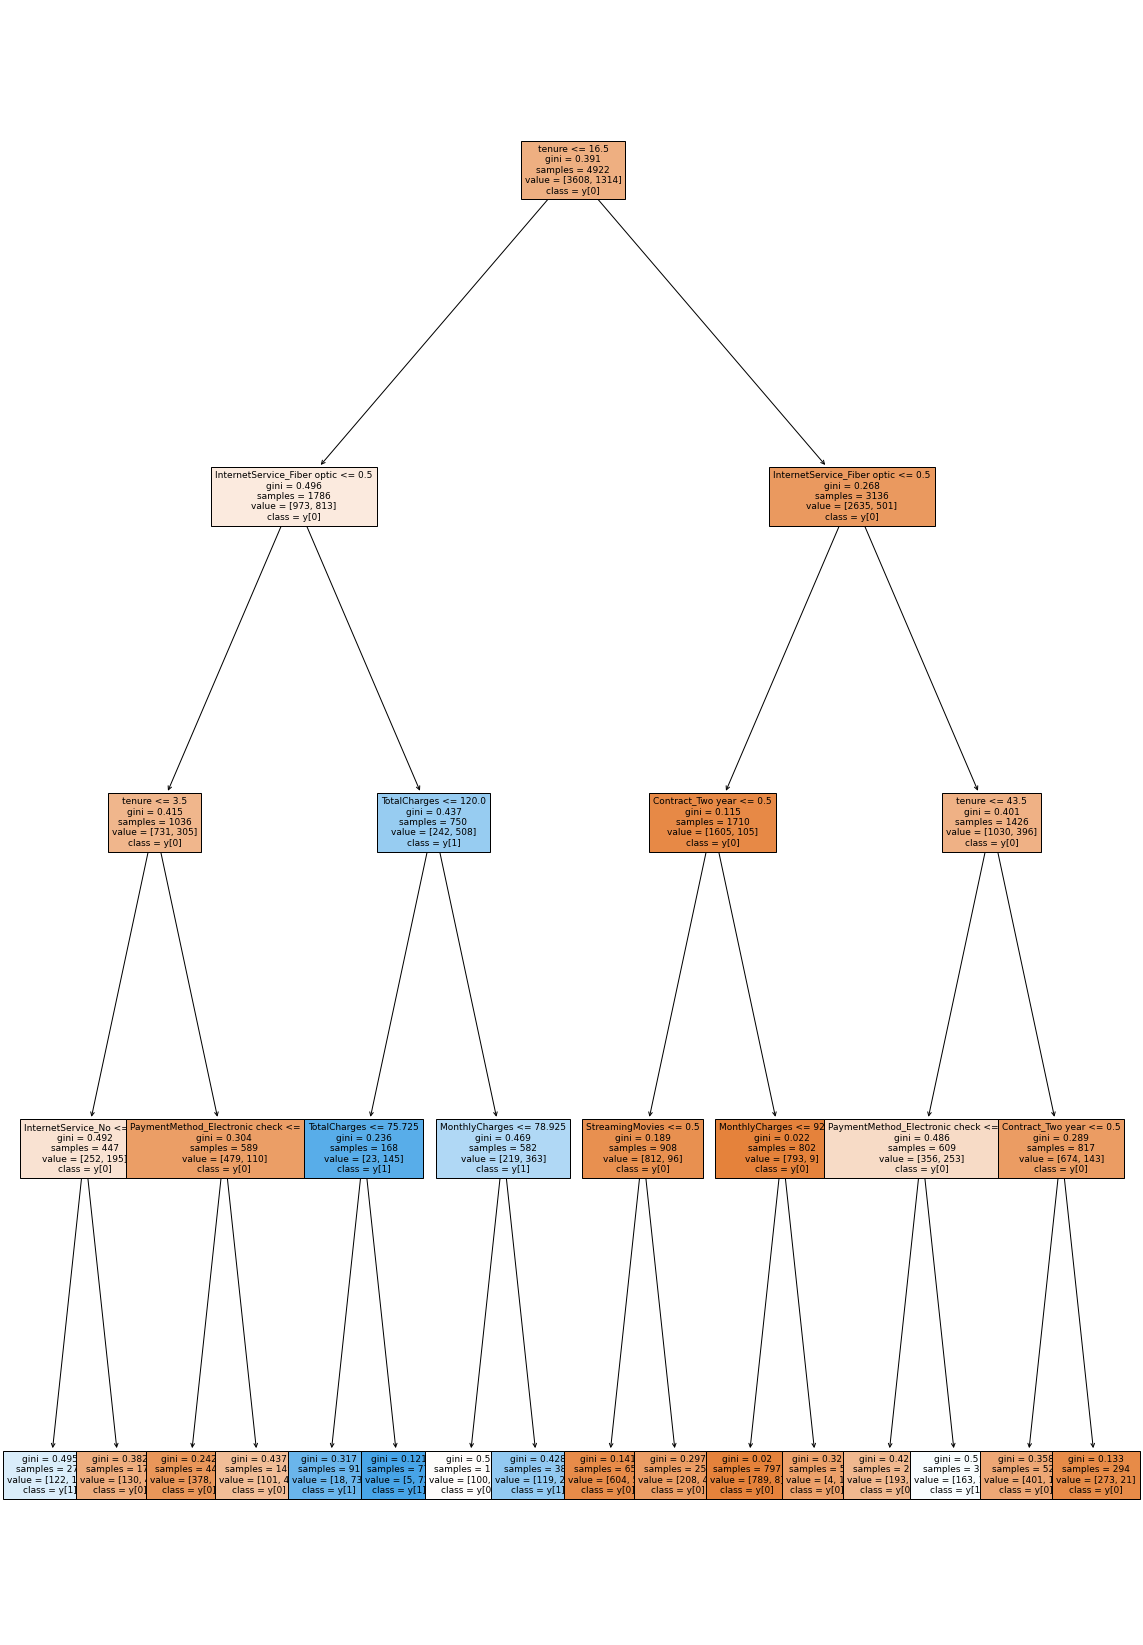

In [102]:
plt.figure(figsize=(20,30))
out = tree.plot_tree(dTree,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=True,)
#below code will add arrows to the decision tree split if they are missing
for o in out:
     arrow = o.arrow_patch
     if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [103]:
# Text report showing the rules of a decision tree -

print(tree.export_text(dTree,feature_names=feature_names,show_weights=True))

|--- tenure <= 16.50
|   |--- InternetService_Fiber optic <= 0.50
|   |   |--- tenure <= 3.50
|   |   |   |--- InternetService_No <= 0.50
|   |   |   |   |--- weights: [122.00, 150.00] class: 1
|   |   |   |--- InternetService_No >  0.50
|   |   |   |   |--- weights: [130.00, 45.00] class: 0
|   |   |--- tenure >  3.50
|   |   |   |--- PaymentMethod_Electronic check <= 0.50
|   |   |   |   |--- weights: [378.00, 62.00] class: 0
|   |   |   |--- PaymentMethod_Electronic check >  0.50
|   |   |   |   |--- weights: [101.00, 48.00] class: 0
|   |--- InternetService_Fiber optic >  0.50
|   |   |--- TotalCharges <= 120.00
|   |   |   |--- TotalCharges <= 75.73
|   |   |   |   |--- weights: [18.00, 73.00] class: 1
|   |   |   |--- TotalCharges >  75.73
|   |   |   |   |--- weights: [5.00, 72.00] class: 1
|   |   |--- TotalCharges >  120.00
|   |   |   |--- MonthlyCharges <= 78.92
|   |   |   |   |--- weights: [100.00, 98.00] class: 0
|   |   |   |--- MonthlyCharges >  78.92
|   |   |   |   |-

In [104]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(dTree.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                                            Imp
tenure                                 0.485238
InternetService_Fiber optic            0.359220
PaymentMethod_Electronic check         0.036043
InternetService_No                     0.033081
Contract_Two year                      0.031316
TotalCharges                           0.029431
MonthlyCharges                         0.018485
StreamingMovies                        0.007185
gender                                 0.000000
PaymentMethod_Credit card (automatic)  0.000000
Contract_One year                      0.000000
PaperlessBilling                       0.000000
StreamingTV                            0.000000
SeniorCitizen                          0.000000
TechSupport                            0.000000
DeviceProtection                       0.000000
OnlineBackup                           0.000000
OnlineSecurity                         0.000000
MultipleLines                          0.000000
PhoneService                           0

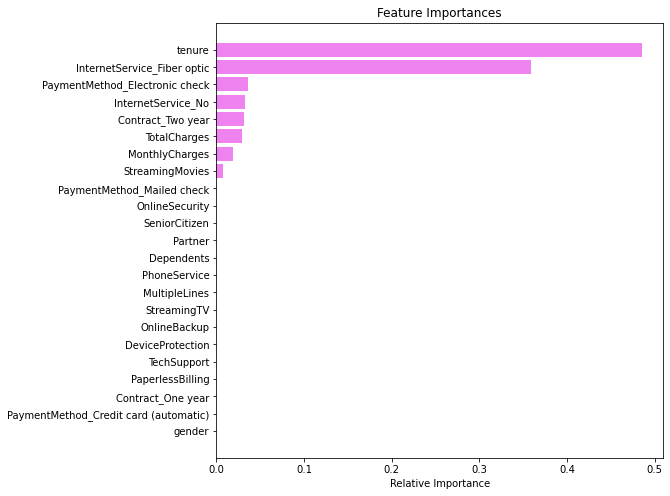

In [105]:
importances = dTree.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Observations

* tenure, InternetService_Fiber optic, PaymentMethod_Electronic check, InternetService_No, Contract_Two year, TotalCharges, MonthlyCharges and StreamingMovies are the important variables
* People who have less than 16.5 years of tenure, do not have fiber optic internet service and receive bills greater than $120 per month are most likely to churn 